In [364]:
from collections import defaultdict
from dateutil.parser import parse
from datetime import datetime
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

%matplotlib inline

In [ ]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [210828,210821,210814,210807,210731,210724,210717,210710,210703,210626,210619,210612]
turnstiles_df = get_data(week_nums)
turnstiles_df.head()

In [376]:
# remove duplicates
turnstiles_df = df[df.DESC != 'RECOVR AUD']
turnstiles_df = df[df.TIME != '04:01:13']
# Sanity check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(df
 .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
2267005,R516,R291,00-00-00,33 ST-RAWSON ST,08/26/2021,00:00:00,2
1087801,N336,R158,00-00-05,KEW GARDENS,06/20/2021,18:30:00,2
1082223,N335,R158,01-00-03,KEW GARDENS,06/20/2021,18:30:00,2
926796,N213,R154,00-00-05,TREMONT AV,06/23/2021,05:00:00,2
2268009,R516,R291,00-00-02,33 ST-RAWSON ST,08/24/2021,16:00:00,2


In [34]:
turnstiles_df['DATETIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME)
turnstiles_df = turnstiles_df.set_index(['DATETIME'])
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2021-08-21 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/21/2021,00:00:00,REGULAR,7622548,2607689
2021-08-21 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/21/2021,04:00:00,REGULAR,7622561,2607697
2021-08-21 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/21/2021,08:00:00,REGULAR,7622573,2607718
2021-08-21 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/21/2021,12:00:00,REGULAR,7622604,2607766
2021-08-21 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/21/2021,16:00:00,REGULAR,7622715,2607802


In [ ]:
# filter dataset to 4am to noon
morning = turnstiles_df.between_time('04:00:00', '12:00:00')
morning.head()

In [143]:
# Subtract the maximum from a minute for each turnstile to get entries
morning_turn = (morning.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['ENTRIES'].max()\
           -morning.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['ENTRIES'].min()).reset_index()
#explore outliers
morning_turn['ENTRIES'].describe()

count    4.194050e+05
mean     2.596817e+03
std      1.074765e+06
min      0.000000e+00
25%      1.000000e+01
50%      4.800000e+01
75%      1.370000e+02
max      6.684988e+08
Name: ENTRIES, dtype: float64

In [92]:
morning_turn['ENTRIES'].sort_values(ascending = True).tail(10)

378552      6217449
131173      7249432
378721      9455949
378720      9456107
399040     11851510
147548     12517454
144128     67109617
144044     67109618
68768     167087795
154750    668498787
Name: ENTRIES, dtype: int64

In [149]:
# removing values that appear to be counter resets
morning_turn = morning_turn[morning_turn.ENTRIES <= 11000]

In [150]:
# add up total  morning ENTRIES per station
morning_station = morning_turn.groupby(['STATION', 'DATE']).sum().reset_index()
morning_station['DATE'] = pd.to_datetime(morning_station['DATE'])
morning_station.head()

,STATION,DATE,ENTRIES
0,1 AV,2021-06-05,1183
1,1 AV,2021-06-06,1030
2,1 AV,2021-06-07,1773
3,1 AV,2021-06-08,1982
4,1 AV,2021-06-09,1974


In [151]:
# summing for whole month
morning_month = morning_station.groupby(['STATION'])['ENTRIES'].sum().reset_index()
morning_month = morning_month.set_index('STATION')

<AxesSubplot:title={'center':'Morning ENTRIES by Station'}, ylabel='STATION'>

<Figure size 720x360 with 0 Axes>

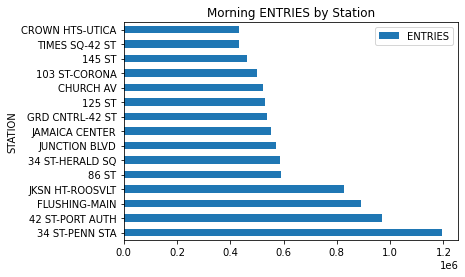

In [273]:
# determine busiest stations
topsts = morning_month.sort_values('ENTRIES', ascending=False).head(15)
plt.figure(figsize=(10, 5))
topsts.head()
topsts.plot(kind='barh', title='Morning ENTRIES by Station')

In [274]:
# limit to Grand Central at turnstile level
grdcentral = df[df['STATION'] == '34 ST-PENN STA']
grdcentral.shape

(51055, 11)

In [275]:
grdcentral.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
55790,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,00:00:00,REGULAR,279314,823670
55791,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,04:00:00,REGULAR,279321,823690
55792,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,08:00:00,REGULAR,279333,823764
55793,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,12:00:00,REGULAR,279403,823894
55794,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,16:00:00,REGULAR,279488,824044


In [344]:
turnstiles = grdcentral['SCP'].unique()

In [414]:
masked_dfs = []
for i in turnstiles:
    mask = grdcentral[((grdcentral["C/A"] == "N067") & 
    (grdcentral["UNIT"] == "R012") & 
    (grdcentral["SCP"] ==  i) & 
    (grdcentral["STATION"] == "34 ST-PENN STA"))]
            
    mask['Final'] = mask['EXITS'].diff()
    masked_dfs.append(mask)
exits_turn = pd.concat(masked_dfs)
exits_turn.head(5)



<ipython-input-414-1e43d60b9ded>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask['Final'] = mask['EXITS'].diff()


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Final
55790,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,00:00:00,REGULAR,279314,823670,NaN
55791,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,04:00:00,REGULAR,279321,823690,20.0
55792,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,08:00:00,REGULAR,279333,823764,74.0
55793,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,12:00:00,REGULAR,279403,823894,130.0
55794,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,16:00:00,REGULAR,279488,824044,150.0


In [416]:
#remove NaN values and negative values (i.e. counter resets)
exits_turn.dropna(inplace=True)
exits_turn = exits_turn[exits_turn['Final'] >= 0]
# now have turnstile exits per four period (diffs column)
exits_turn.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Final
55924,N067,R012,00-06-01,34 ST-PENN STA,ACE,IND,06/11/2021,04:00:00,REGULAR,458752,230,1.0
55925,N067,R012,00-06-01,34 ST-PENN STA,ACE,IND,06/11/2021,08:00:00,REGULAR,458752,230,0.0
55926,N067,R012,00-06-01,34 ST-PENN STA,ACE,IND,06/11/2021,12:00:00,REGULAR,458752,230,0.0
55927,N067,R012,00-06-01,34 ST-PENN STA,ACE,IND,06/11/2021,16:00:00,REGULAR,458752,230,0.0
55928,N067,R012,00-06-01,34 ST-PENN STA,ACE,IND,06/11/2021,20:00:00,REGULAR,458752,230,0.0


In [417]:
exits_turn.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Final
55791,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,04:00:00,REGULAR,279321,823690,20.0
55792,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,08:00:00,REGULAR,279333,823764,74.0
55793,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,12:00:00,REGULAR,279403,823894,130.0
55794,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,16:00:00,REGULAR,279488,824044,150.0
55795,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,08/21/2021,19:01:14,REGULAR,279548,824188,144.0
